In [1]:
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detokenizer
import re
from nltk.stem.snowball import SnowballStemmer

# Function to clean/ pre-process the text
def clean_text(text):
    #stop_words = set(stopwords.words('english'))
    stop_words = set(['a', 'an', 'the', 'and', 'or', 'but', 'although', 'however'])
    #word_tokens = word_tokenize(text)
    word_tokens = text.split()
    filtered_tokens = [w for w in word_tokens if not w in stop_words]
    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(w) for w in filtered_tokens]
    detokenizer = Detokenizer()
    text = detokenizer.detokenize(stemmed_tokens)
    text = re.sub('\s*,\s*', ', ', text)
    text = re.sub('\s*\.\s*', '. ', text)
    text = re.sub('\s*\?\s*', '? ', text)
    return text

In [16]:
import pandas as pd
import numpy as np


data=pd.read_excel('processed1.xlsx') #Include your data file instead of data.xlsx
review=data.iloc[:,0:8] #Selecting the first column that has text.

#Converting the column of data from excel sheet into a list of documents, where each document corresponds to a group of sentences.
corpus, wc_corpus = [], []

for index, row in review.iterrows():
    corpus.append(clean_text(row['benefitsReview']))
    wc_corpus.append(row['benefitsReview'])

#Count Vectoriser then tidf transformer

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

#print(X)

#vectorizer.get_feature_names()

#print(X.toarray())

from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(X)
print(tfidf.shape) 
#print(tfidf)

from sklearn.cluster import KMeans

num_clusters = 4 #Change it according to your data.
km = KMeans(n_clusters=num_clusters)
kmclusters = km.fit_predict(tfidf)
clusters = km.labels_.tolist()

review={'benefitReview':corpus, 'Cluster':clusters} #Creating dict having doc with the corresponding cluster number.
frame=pd.DataFrame(review,index=[clusters], columns=['benefitReview','Cluster']) # Converting it into a dataframe.

#print("\n")
#print(frame) #Print the doc with the labeled cluster number.
#print("\n")
print(frame['Cluster'].value_counts()) #Print the counts of doc belonging to each cluster.

(895, 3614)
0    408
1    384
3     83
2     20
Name: Cluster, dtype: int64


C:\Users\apurv\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\apurv\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\apurv\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


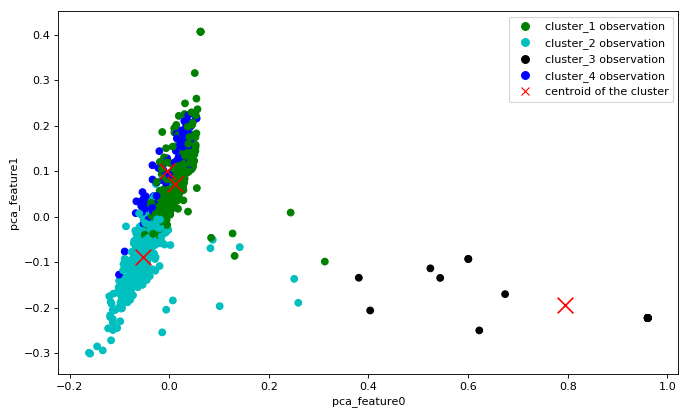

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

LABEL_COLOR_MAP = {0 : 'g',
                   1 : 'c',
                   2 : 'k',
                   3 : 'b'
                  }

label_color = [LABEL_COLOR_MAP[l] for l in km.labels_]

marker1 = mlines.Line2D([], [], color='g', marker='o', linestyle='None', markersize=7, label='cluster_1 observation')
marker2 = mlines.Line2D([], [], color='c', marker='o', linestyle='None', markersize=7, label='cluster_2 observation')
marker3 = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=7, label='cluster_3 observation')
marker4 = mlines.Line2D([], [], color='b', marker='o', linestyle='None', markersize=7, label='cluster_4 observation')
marker5 = mlines.Line2D([], [], color='r', marker='x', linestyle='None', markersize=7, label='centroid of the cluster')

pca = PCA(n_components=2).fit(tfidf.toarray())
data2D = pca.transform(tfidf.toarray())
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(data2D[:,0], data2D[:,1], c=label_color)
centers2D = pca.transform(km.cluster_centers_)
plt.xlabel('pca_feature0')
plt.ylabel('pca_feature1')
plt.legend(handles=[marker1, marker2, marker3, marker4, marker5])
plt.hold(True)
plt.scatter(centers2D[:,0], centers2D[:,1], marker='x', s=200, linewidths=3, c='r')
plt.show()

In [19]:
# Get all documents in cluster 0
cluster_0 = np.where(kmclusters==0)
# Get all documents in cluster 1
cluster_1 = np.where(kmclusters==1)
# Get all documents in cluster 2
cluster_2 = np.where(kmclusters==2)
# Get all documents in cluster 3
cluster_3 = np.where(kmclusters==3)

# cluster_0 now contains all indices of the documents in this cluster, to get the actual documents you'd do:
#X_cluster_0 = tfidf[cluster_0]
# cluster_1 now contains all indices of the documents in this cluster, to get the actual documents you'd do:
#X_cluster_1 = tfidf[cluster_1]
# cluster_2 now contains all indices of the documents in this cluster, to get the actual documents you'd do:
#X_cluster_2 = tfidf[cluster_2]
# cluster_3 now contains all indices of the documents in this cluster, to get the actual documents you'd do:
#X_cluster_3 = tfidf[cluster_3]

from scipy.spatial.distance import euclidean
# Distance for 1 document to 1 cluster centroid
#distance = euclidean(X_cluster_0[0].A[0], km.cluster_centers_[0])
#print(distance)

dist_0 = []
for index in cluster_0[0]:
    distance = euclidean(tfidf[index].A[0], km.cluster_centers_[0])
    dist_0.append(distance)
#print(dist_0)

dist_1 = []
for index in cluster_1[0]:
    distance = euclidean(tfidf[index].A[0], km.cluster_centers_[1])
    dist_1.append(distance)

dist_2 = []
for index in cluster_2[0]:
    distance = euclidean(tfidf[index].A[0], km.cluster_centers_[2])
    dist_2.append(distance)

dist_3 = []
for index in cluster_3[0]:
    distance = euclidean(tfidf[index].A[0], km.cluster_centers_[3])
    dist_3.append(distance)

dist_n0, dist_n1, dist_n2, dist_n3 = [], [], [], []
indices = []
for index in range(0,895):
    distance = euclidean(tfidf[index].A[0], km.cluster_centers_[0])
    dist_n0.append(distance)
    distance = euclidean(tfidf[index].A[0], km.cluster_centers_[1])
    dist_n1.append(distance)
    distance = euclidean(tfidf[index].A[0], km.cluster_centers_[2])
    dist_n2.append(distance)
    distance = euclidean(tfidf[index].A[0], km.cluster_centers_[3])
    dist_n3.append(distance)
    indices.append(index)

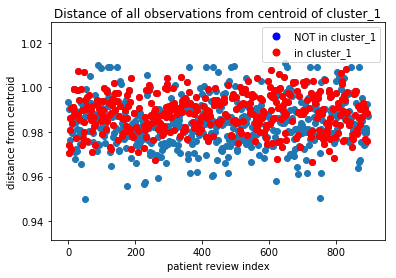

In [20]:
marker1 = mlines.Line2D([], [], color='b', marker='o', linestyle='None', markersize=7, label='NOT in cluster_1')
marker2 = mlines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=7, label='in cluster_1')
plt.scatter(indices, dist_n0)
plt.scatter(cluster_0[0], dist_0, c='r')
plt.xlabel('patient review index')
plt.ylabel('distance from centroid')
plt.title('Distance of all observations from centroid of cluster_1')
plt.legend(handles=[marker1, marker2])

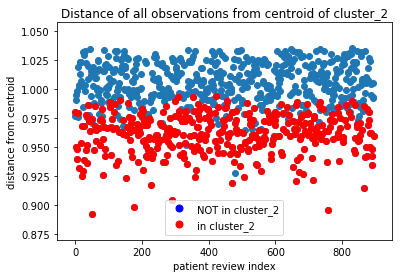

In [21]:
marker1 = mlines.Line2D([], [], color='b', marker='o', linestyle='None', markersize=7, label='NOT in cluster_2')
marker2 = mlines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=7, label='in cluster_2')
plt.scatter(indices, dist_n1)
plt.scatter(cluster_1[0], dist_1, c='r')
plt.xlabel('patient review index')
plt.ylabel('distance from centroid')
plt.title('Distance of all observations from centroid of cluster_2')
plt.legend(handles=[marker1, marker2])

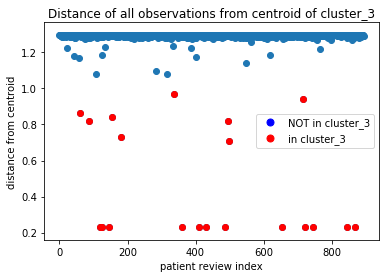

In [22]:
marker1 = mlines.Line2D([], [], color='b', marker='o', linestyle='None', markersize=7, label='NOT in cluster_3')
marker2 = mlines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=7, label='in cluster_3')
plt.scatter(indices, dist_n2)
plt.scatter(cluster_2[0], dist_2, c='r')
plt.xlabel('patient review index')
plt.ylabel('distance from centroid')
plt.title('Distance of all observations from centroid of cluster_3')
plt.legend(handles=[marker1, marker2])

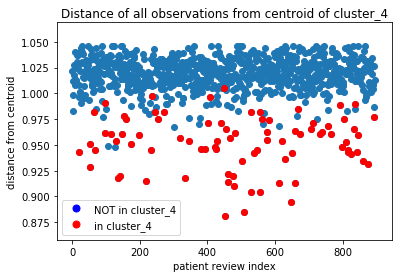

In [23]:
marker1 = mlines.Line2D([], [], color='b', marker='o', linestyle='None', markersize=7, label='NOT in cluster_4')
marker2 = mlines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=7, label='in cluster_4')
plt.scatter(indices, dist_n3)
plt.scatter(cluster_3[0], dist_3, c='r')
plt.xlabel('patient review index')
plt.ylabel('distance from centroid')
plt.title('Distance of all observations from centroid of cluster_4')
plt.legend(handles=[marker1, marker2])

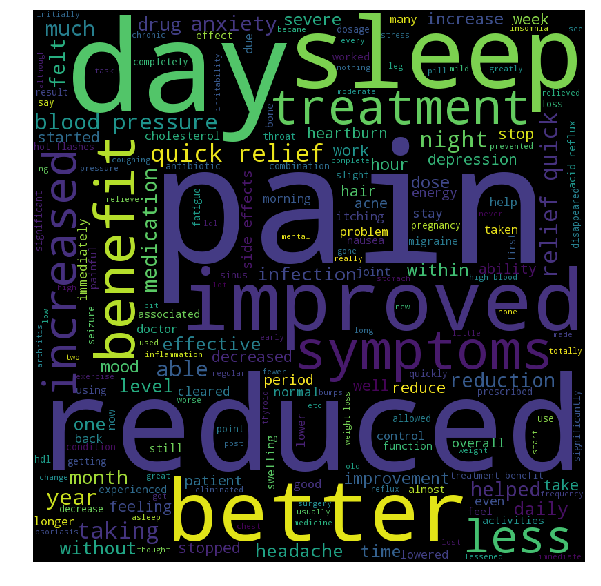

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
  
comment_words = ' '
stopwords = set(STOPWORDS)

# iterate through the csv file
for index in cluster_0[0]:
      
    # typecaste each val to string
    val = wc_corpus[index]
    #print(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    # Add words to the final string
    for words in tokens:
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

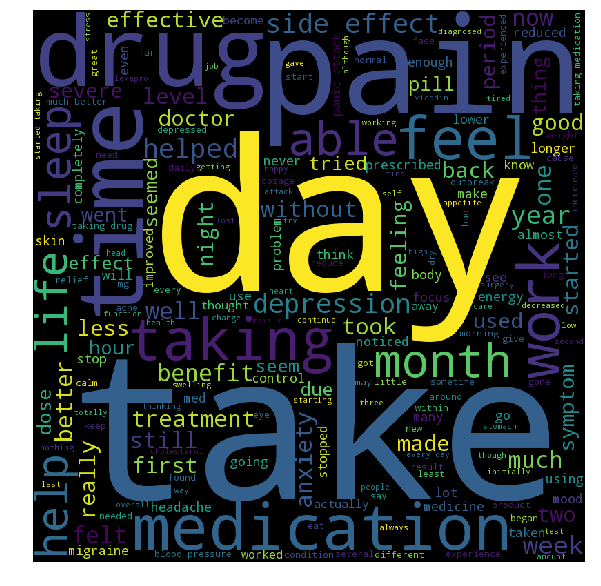

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ' '
stopwords = set(STOPWORDS)

# iterate through the csv file
for index in cluster_1[0]:
      
    # typecaste each val to string
    val = wc_corpus[index]
    #print(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    # Add words to the final string
    for words in tokens:
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

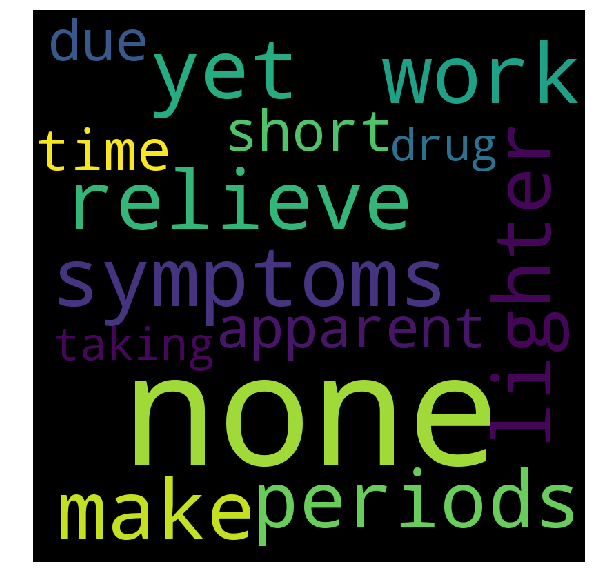

In [26]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
  
comment_words = ' '
stopwords = set(STOPWORDS)

# iterate through the csv file
for index in cluster_2[0]:
      
    # typecaste each val to string
    val = wc_corpus[index]
    #print(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    # Add words to the final string
    for words in tokens:
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

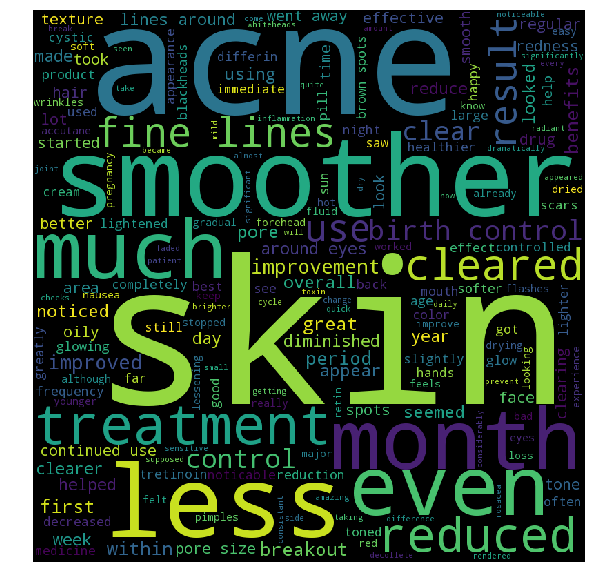

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
  
comment_words = ' '
stopwords = set(STOPWORDS)

# iterate through the csv file
for index in cluster_3[0]:
      
    # typecaste each val to string
    val = wc_corpus[index]
    #print(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    # Add words to the final string
    for words in tokens:
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [28]:
from sklearn import metrics
labels = km.labels_
print(metrics.silhouette_score(tfidf, labels, metric='euclidean'))
print(metrics.calinski_harabaz_score(tfidf.toarray(), labels))

0.018379445051192645
9.501017887994273


In [15]:
data=pd.read_excel('processed1.xlsx') #Include your data file instead of data.xlsx
review=data.iloc[:,0:8] 
condition = []
for index, row in review.iterrows():
    condition.append(row['condition'])